In [20]:
import pandas as pd
import akshare as ak
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [68]:
stock_zh_index_spot_df = ak.stock_zh_index_spot()
stock_zh_index_spot_df[stock_zh_index_spot_df['名称'].str.contains('转债')]

,代码,名称,最新价,涨跌额,涨跌幅,昨收,今开,最高,最低,成交量,成交额
122,sh000139,上证转债,338.2625,0.774,0.229,337.4888,337.3318,338.3071,336.4151,11345833,14409586288
275,sz399307,深证转债,279.4570,1.045,0.375,278.4120,278.3580,279.7080,277.0230,141481292,20604181660
364,sz399413,国证转债,143.2790,0.403,0.282,142.8760,142.8230,143.3270,142.3340,254939622,35013767948


In [26]:
def calculate_max_drawdown(df, col_name: str):
    max_drawdown = 0
    peak = df[col_name][0]

    for nav in df[col_name]:
        if nav > peak:
            peak = nav
        drawdown = (peak - nav) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    return max_drawdown * 100

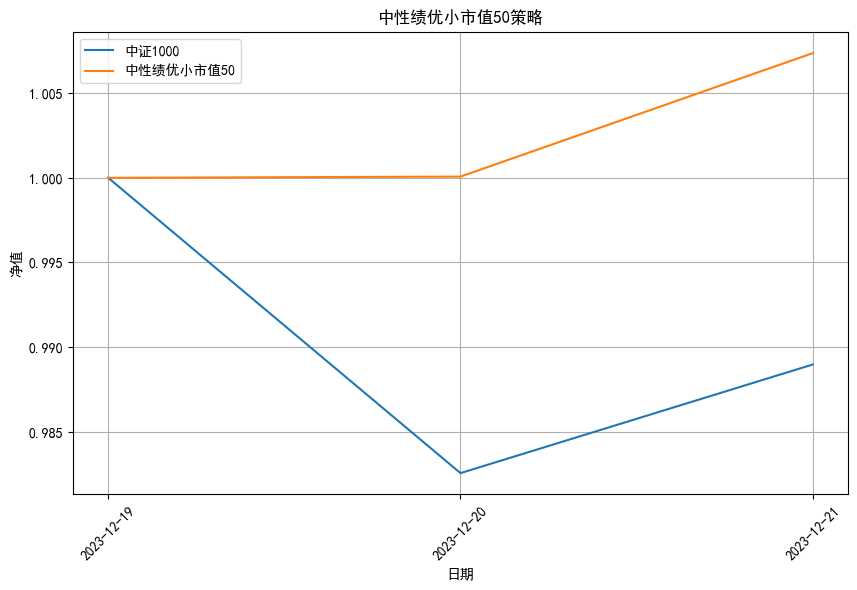

策略净值: 1.0074
基准-中证1000净值: 0.989
超额收益: 1.838%
估测年化收益: 85.146%
最大回撤: 0%


In [70]:
# params
def plot_strategy(start_date: date, index_symbol: str, strategy_path: str, strategy_net_val_col: str, basic_index_name: str = '中证1000', strategy_name: str = ''):
    # base index df
    daily_df = ak.stock_zh_index_daily(symbol=index_symbol)
    raw_length = len(daily_df)
    daily_df = daily_df[daily_df['date'] >= start_date]
    start_idx = daily_df.index[0]
    daily_df['daily_ret'] = daily_df['close'].pct_change()
    daily_df.at[start_idx, 'net_val'] = 1.0
    for i in range(start_idx + 1, raw_length):
        daily_df.at[i, 'net_val'] = daily_df.at[i - 1, 'net_val'] * (1 + daily_df.at[i, 'daily_ret'])
    # strategy df 
    strategy_df = pd.read_excel(strategy_path)
    # plot graph
    daily_df['date'] = daily_df['date'].astype('str')
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(10, 6))
    plt.plot(daily_df['date'], daily_df['net_val'], label=basic_index_name)
    plt.plot(daily_df['date'], strategy_df[strategy_net_val_col], label=strategy_name)

    plt.title(f'{strategy_name}策略')
    plt.xlabel('日期')
    plt.ylabel('净值')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()

    plt.show()
    # print
    index_net_val = daily_df.iloc[-1]['net_val']
    strategy_net_val = strategy_df.iloc[-1][strategy_net_val_col]
    extra_ret = (strategy_net_val - index_net_val) * 100
    length = len(daily_df)
    year_ret = (strategy_net_val ** (252 / length) - 1) * 100
    print(f"策略净值: {round(strategy_net_val, 4)}")
    print(f"基准-{basic_index_name}净值: {round(index_net_val, 4)}")
    print(f"超额收益: {round(extra_ret, 3)}%")
    print(f"估测年化收益: {round(year_ret, 3)}%")
    print(f"最大回撤: {round(calculate_max_drawdown(strategy_df, strategy_net_val_col), 3)}%")


plot_strategy(date(2023, 12, 19), 'sh000852','./positions/绩优小市值轮动.xlsx', '总净值', strategy_name='中性绩优小市值50')

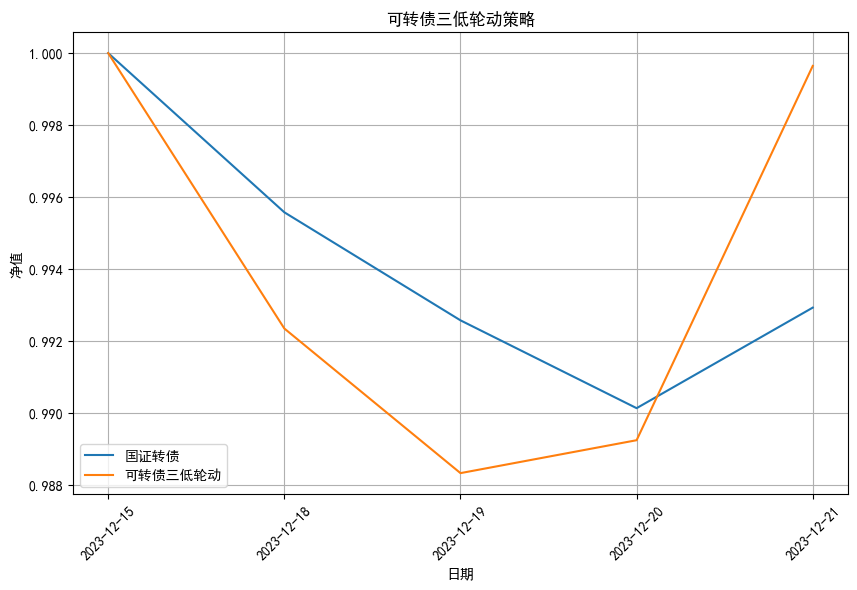

策略净值: 0.9996
基准-国证转债净值: 0.9929
超额收益: 0.671%
估测年化收益: -1.775%
最大回撤: 1.167%


In [71]:
plot_strategy(date(2023, 12, 15), 'sz399413','./positions/可转债三低轮动.xlsx', '净值', 
              strategy_name='可转债三低轮动', basic_index_name='国证转债')